# Deterministic policy gradient for discrete actions

__tldr:__ we describe and implement a [[DPG]](http://proceedings.mlr.press/v32/silver14.pdf) for discrete action spaces using gumbel-softmax and articulate on why it matters. It has better variance. It's off-policy. It's cool.

__Prerequesites:__ [[basic rl]](http://karpathy.github.io/2016/05/31/rl/),  [[gumbel-softmax]](http://blog.evjang.com/2016/11/tutorial-categorical-variational.html)

__Authors:__ spontaneous brain eruption during the seminar [[practical-rl]](https://github.com/yandexdataschool/practical_rl) reading group. In retrospect, this may or may not have originated from [[Pasha Shvechikov]](1xolodec@gmail.com). 

We're somewhat affiliated with [[Yandex School of Data Analysis]](https://github.com/yandexdataschool), [[Yandex Machine Intelligence Research]](https://yandex.com/company/blog/introducing-yandex-s-machine-intelligence-and-research-division/) and [[Computer Science @ HSE]](https://cs.hse.ru/en/).

### TOC:
1. [Stochastic policy gradient](#intro_reinforce)
2. [Deterministic policy gradient](#intro_dpg)
3. [Gumbel-softmax](#intro_gumbel)
4. [Gumbel-DPG](#gumbel_dpg)
5. [Hack zone](#hacks)
6. [Code](#implementation)
7. [Analysis](#outro)

__Note__: this algorithm was a popular folklore in our reading group, but we failed to Google-up a paper that suggests it. If you know a paper about discrete DPG with Gumbel that came before this post, ping [[me]](jheuristic@yandex-team.ru) asap.

Until you do so, by _jus primae noctis_ we hereby proclaim it __DDDPGG__ for Discrete Deep Deterministic Policy Gradient with Gumbel-softmax. This title was intended to make both Asynchronuous Advantage Actor-Critic and Deep Deterministic Policy Gradient feel miserable. Or just call it Gumbel-DPG if you're not feeling masochistic.

### Stochastic policy gradient  <a id="intro_reinforce" > </a>

The usual way to do reinforcement learning with stochastic policy $\pi(a|s)$ is by following stochastic policy gradient $\nabla J$.

$$\nabla J = \underset{s}{E} \space \underset{a \sim \pi(a|s)}{E} \space \nabla \log \pi(a|s) \cdot Q(s,a)$$

Here and below,
* s = state, a = action, r = reward
* Q(s,a,) is the expected cummulative reward $ Q(s,a) = E \space G_\pi(s,a) = E \space r(s,a) + \gamma \cdot r(s',a') + \gamma^2 \cdot ...$

The simplest algorithm to use this, REINFORCE, does the following:

1. $<s_0, a_0, r_0, s_1, a_1, r_1, ... , s_n, a_n, r_n>$ = play full game with $\pi(a|s)$
2. Compute cummulative rewards $G_t$ from $r_t$
3. Compute $ \nabla J \approx {1 \over n} \underset{t}{\sum} \nabla \log \pi(a_t|s_t) \cdot G_t$ 
4. Ascend $\nabla J$ over $\pi(a|s)$

REINFORCE works well for both discrete and continuous action spaces. Technically you can approach any reinforcement learning problem with it. The catch is that it converges slowly due to high variance in $\nabla J$. There's a number of enhancements: advantage actor-critic, TRPO, self-critical sequence training. Those enhancements reduce the variance and add some perks like learning from partial experience, but they exploit the same core idea.

### Deterministic policy gradient <a id='intro_dpg'></a>

When action space is continuous, $a \in \mathbb{R} $, you can use the idea from [[deterministic policy gradient]](http://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html):

$$ \nabla J = \underset{s,a \sim \pi}{E} {{\partial Q(s,a)} \over {\partial a}} \cdot {{\partial a} \over {\partial \pi(a|s)}} $$

Here, $\pi(a|s)$ is some continuous distribution for which you can use [[reparameterization trick]](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/). For example, Normal distribution, where you can compute $ \nabla N(\mu,\sigma) = \nabla \mu + \nabla \sigma \cdot N(0,1) \space $ Pardon my french.

In practice, you can approximate $\pi$ with a ~~neural network~~ parametric model:

<img src='https://s21.postimg.org/9tpiq4dzb/actor.png' width=320>

For model-free setting, Q(s,a) is also approximated with ~~another neural network~~ a parametric model, so computing $ \partial Q / \partial a $ boils down to backpropagation through that network:

<img src='https://s11.postimg.org/jbc1l8q8j/critic.png' width=240>

We can train Q(s,a) with simple [TD](http://incompleteideas.net/sutton/book/ebook/node60.html) loss. We used loss from Q-learning (see [appendix](#appendix)):

$$ L_{critic} = \underset{s,a,r,s'}{E} \space (Q(s,a) - [r+\gamma \cdot Q(s',a'_{max}(s'))])^2 $$ 
<center>($a_{max}$ is most likely action)</center>



Now we can feed action from actor into critic and propagate gradients backward:

<img src='https://s16.postimg.org/5cz4v71zp/dpg.png' width=480>


For normal distribution, this backpropagation becomes

$$ \nabla_\theta J = \underset{s,a \sim \pi}{E}{{\partial Q(s,a)} \over {\partial [\mu_\theta(s) + \sigma_\theta(s)\cdot \xi]}} \cdot {{\partial [\mu_\theta(s) + \sigma_\theta(s)\cdot \xi]} \over {\partial \theta}} $$

__Intuitively__, the difference between REINFORCE and DPG is that given just one sample action $a \sim \pi(a|s)$, 
* REINFORCE tells you: "This action is bad. Don't use it. Use other actions."
* DPG tells you: "This action is bad. Move mu and sigma this way to get better."

The second message is more informative as it gives you instructions on _which direction to follow:_ ${{\partial Q(s,a)} \over {\partial a}}$.

__Mathematically__, it's all about tricks: REINFORCE uses [[log-derivative trick]](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/), while DPG uses [[reparameterization trick]](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/). The latter introduces less variance, but it's only available for some $pi$ distributions.

One additional boon of DPG is that it can be used __off-policy__. This allows for all cool things from pre-training on human expert data to experience replay for greater sample efficiency.


### Discrete DPG with Gumbel-softmax <a id="intro_gumbel"></a>

The title of this paragraph is a nonsense. Formally speaking, you can't compute ${{\partial a} \over {\partial \pi(a|s)}}$ if $a$ is a discrete variable. What you can do is replace discrete $a \sim \pi(a|s)$ with some continuous distribution which resembles it. One trick that fits the bill is Gumbel-Softmax. 


For discrete action spaces you usually represent agent's policy as a neural network with one output neuron for each action with softmax nonlinearity. We're now gonna add a special [[Gumbel]](https://en.wikipedia.org/wiki/Gumbel_distribution) noise before softmax. Here's how to get the that noise:

$$ g = -log(-log(U)) $$

<center>where U is a uniform distribution in [0,1]</center>


/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


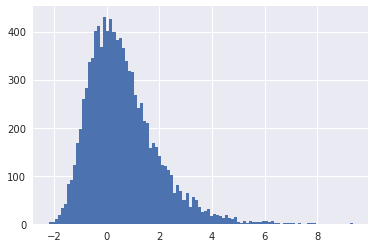

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

e = 1e-50 #epsilon for stability

gumbel = lambda size=None: -np.log(-np.log(np.random.uniform(0,1,size)+e)+e)

plt.hist(gumbel(10000),bins=100);

As you can see, this distribution has quite a fat tail. If you add it before softmax, it will likely make one class dominant and put others near zero.

We're now going to build a vector of softmax "probabilities" with gumbel noise added independently to each logit.

$$\hat a = [\frac{\text{exp}((\log(\pi(a_i|s))+g_i)/\tau)}{\sum_{j=1}^k \text{exp}((\log(\pi(a_j|s))+g_j)/\tau)} \qquad \text{for } i=1, ..., k ]$$

Let's denote that vector as

$$ \hat a \sim gumbel(\pi(a|s);\tau) $$

Note that we divide by "temperature" $\tau$: this is gonna be important next paragraph.

In [2]:
softmax = lambda logits: np.exp(logits) / np.exp(logits).sum(axis=-1)

gumbel_softmax = lambda logits, tau=1.: softmax((logits + gumbel(logits.shape))/tau)

This distribution has a few nice properties that we're gonna use:
* It's differentiable: $ {{\partial \hat a} / {\partial \pi}}$
* Taking $\underset{a_i}{argmax} \space gumbel(\pi(a_i|s))$ is equivalent to sampling from $a \sim \pi(a|s)$
* _For small temperatures_ ($ \tau \rightarrow 0 $), $\hat a$ gets closer to one-hot vector of $a \sim \pi(a|s)$

Let's illustrate the last property:

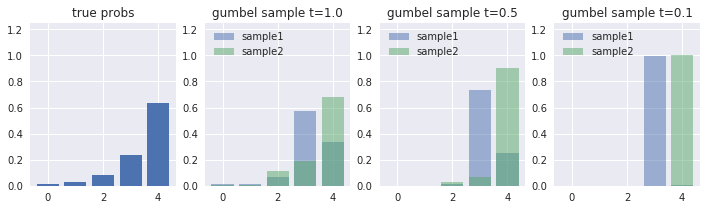

In [3]:
logits = np.arange(5)    #unnormalized log-probabilities. Go play with it :)
taus = [1.,0.5,0.1]     #which tau to plot

ids = np.arange(len(logits))
probs = softmax(logits)

plt.figure(figsize=[12,3])
plt.subplot(1,len(taus)+1,1)
plt.bar(ids,probs,alpha=1)
plt.title('true probs')
plt.ylim(0,1.25)


for i,tau in enumerate(taus):
    np.random.seed(111)
    plt.subplot(1,len(taus)+1,i+2)
    plt.bar(ids,gumbel_softmax(logits,tau),alpha=0.5,label='sample1')
    plt.bar(ids,gumbel_softmax(logits,tau),alpha=0.5,label='sample2')
    plt.legend(loc='upper left')
    plt.title('gumbel sample t=%.1f'%tau)
    plt.ylim(0,1.25)



Gumbel-softmax trick has already gained a few applications. There's a neat blog post about VAEs with gumbel-softmax [[here]](http://blog.evjang.com/2016/11/tutorial-categorical-variational.html). There's also some adversarial nets [[here]](https://arxiv.org/abs/1611.04051). The common trick is to start with, say, $\tau_0=1$, and then steadily decrease $\tau$ as you train your algorithm.

In general, you use gumbel-softmax if you want some continuous methods to work on discrete variables. Aham! This is exactly where we were with deterministic policy gradient!

### Gumbel-DPG <a id="gumbel_dpg"></a>

So, what changes in our DPG scheme? We substitute normal distribution with a gumbel-softmax distribution and such actor:

<img src="https://s24.postimg.org/mgpxidm9h/gumbel_actor.png" width=440>

The DPG scheme didn't change a bit:

<img src="https://s2.postimg.org/4yfq3wpu1/gumbel_dpg.png" width=480>

Note that the entire scheme here is fully differentiable:

$$ {{\partial Q(s,\hat a)} \over {\partial \theta}} = {{\partial Q(s,\hat a))} \over {\partial \hat a}} \cdot {{\partial \hat a} \over {\partial \pi_\theta(a|s)}} \cdot {{\partial \pi_\theta(a|s)} \over {\partial \theta}} $$


So here's our plan:

1. Initialize $\pi_\theta(a|s)$ and $Q_\phi(s,\hat a)$ at random
2. Initialize $\tau = 1$
3. Forever:
4. $\quad s = current\_state()$
5. $\quad a = gumbel(\pi_\theta(a|s); \tau)$
6. $\quad$train Actor by _ascending_ $ {{\partial Q_\phi(s,\hat a)} / {\partial \theta}} $ over $\theta$
7. $\quad s',r = get\_action\_result(s,a)$
8. $\quad$train critic by descending $\nabla (Q_\phi(s,a) - [r+\gamma \cdot \space Q_\phi(s', \underset{a'}{argmax\space}\pi_\theta(a'|s'); \tau))])^2 $ over $\phi$
9. $\quad$decrease $\tau$

__Note:__ lines 6 and 8 only take a single step (or a few steps) following the gradient to avoid overfitting to a single interaction.

__Note 2:__ to clarify line 8: we compute $a'_{max}(s') = \underset{a'}{argmax\space}\pi_\theta(a'|s')$ and then plug $Q_\phi(s',a'_{max}(s')$ into critic loss.

### Hack zone <a id="hacks"></a>

Since DPG is an off-policy algorithm, you can use this property by training on experience replay like in [[DQN]](https://www.nervanasys.com/demystifying-deep-reinforcement-learning/)_[ctrl+f experience replay there]_. There's also [[prioritized experience replay]](https://arxiv.org/abs/1511.05952) available. 

You can use target networks to stabilize critic ([[regular]](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)_[see addition 3]_,[[soft]](https://arxiv.org/pdf/1509.02971.pdf)_[ctrl+f "slowly track"]_). 

One other common hach for all policy gradient algorithms is regularizing actor with entropy (more=better). This trick prevents premature convergence for the cost of introducing yet another parameter.

### Finally, let's code it! <a id="implementation"> </a>

The usual story: use gym for environment, code in theano with easy conversion to tensorflow/pytorch.

In [4]:
#recording video on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ./xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


[2017-06-16 15:46:16,652] Making new env: CartPole-v0


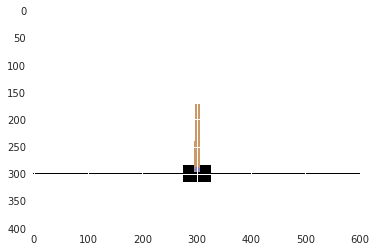

In [5]:
#here's our env
import gym
make_env = lambda: gym.make("CartPole-v0")

env = make_env()
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

#### Building actor and critic

We define two lasagne networks to be used as actor and critic accordingly.

In [6]:
%env THEANO_FLAGS=floatX=float32
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
from gumbel import GumbelSoftmaxLayer
tau = theano.shared(np.float32(0.01),name="tau",allow_downcast=True)

env: THEANO_FLAGS=device=gpu2,floatX=float32


[2017-06-16 15:46:18,142] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX 1080 (CNMeM is enabled with initial size: 22.0% of memory, cuDNN 5110)


__Actor__

In [7]:
actor = InputLayer((None,)+state_dim)
actor = DenseLayer(actor,128)
actor = DenseLayer(actor,n_actions,nonlinearity=None)

actor_gumbel = GumbelSoftmaxLayer(actor,tau)            #a hat
actor_softmax = NonlinearityLayer(actor,T.nnet.softmax) #action probabilities


In [8]:
states = T.matrix("states")

policy, gumbel_action = get_output([actor_softmax,actor_gumbel],states) #pi(a|s) and a_hat

get_gumbel_action = theano.function([states],gumbel_action, allow_input_downcast=True)
get_policy = theano.function([states],policy, allow_input_downcast=True)

__Critic__

In [9]:
critic_state = InputLayer((None,)+state_dim)
critic_action = InputLayer((None,n_actions)) # a hat

critic = ConcatLayer([critic_state,critic_action])
critic = DenseLayer(critic,256)
critic = DenseLayer(critic,1,nonlinearity=None) # Q(s,a)

from target_network import TargetNetwork
target_net = TargetNetwork(critic,share_inputs=True)
old_critic = target_net.output_layers

#### Training

In [10]:
# Train actor with deterministic policy gradient
qvalues = get_output(critic,{critic_state:states,critic_action:gumbel_action})

#Optional: add entropy to encourage exploration
reg_entropy = -(policy * T.log(policy)).sum(axis=-1).mean()

#maximize qvalues by minimizing negative qvalues
actor_loss = -qvalues.mean() - 1e-2*reg_entropy

actor_weights = get_all_params(actor,trainable=True)

actor_updates = lasagne.updates.adam(actor_loss, actor_weights)

#function to perform one step of policy gradient ascent over theta
train_actor = theano.function([states],actor_loss, updates = actor_updates,
                               allow_input_downcast=True)


In [11]:
# Train critic with temporal difference loss. We use the neat but unefficient version. 
actions = T.matrix("a_hat recorded from current tick")
rewards = T.vector("reward r(s,a)")
next_states = T.matrix("new state")
is_done = T.vector("whether game is finished by next state")
gamma = 0.99

#get Q(s, a)
current_qvalues = get_output(critic, {critic_state:states, critic_action:actions})
criticise = theano.function([states,actions],current_qvalues)

#get a'_max(s')
best_next_action = get_output(actor_softmax,next_states).argmax(axis=-1)
best_next_action_1hot = T.extra_ops.to_one_hot(best_next_action,n_actions,dtype='float32')

#Q_target(s',a'_max(s'))
next_best_qvalue = get_output(old_critic, {critic_state:next_states,
                                           critic_action:best_next_action_1hot})

#account for possible game end
next_best_qvalue *= (1-is_done)

#critic loss
from theano.gradient import disconnected_grad as const
reference_qvalue = const(rewards + gamma*next_best_qvalue)

critic_loss = T.mean((current_qvalues - reference_qvalue)**2)

critic_params = get_all_params(critic,trainable=True)

critic_updates = lasagne.updates.adam(critic_loss,critic_params,learning_rate=1e-4)

#perform one step of critic gradient descent over phi
train_critic = theano.function([states,actions,rewards,next_states,is_done],critic_loss,
                               updates = critic_updates, allow_input_downcast=True)

### Experience replay

We also need to implement an experience replay buffer to store and... replay the... experience. Technically speaking, such buffer is a storage of `<s,a,r,s'>` from which we sample those tuples when training the DQN.

Implementing experience replay is easy, but doing so efficiently requires some data structure hacks. Fortunately, OpenAI have recently [[published]](https://blog.openai.com/openai-baselines-dqn/) their DQN implementation with experience replay buffer. So we stole it :)

In [12]:
from tqdm import tqdm,trange
from replay_buffer import ReplayBuffer

replay_buffer = ReplayBuffer(size=10**5)

# pre-fill buffer
s = env.reset()
for _ in trange(10000):
    action = get_gumbel_action([s])[0]            # a hat from gumbel(pi(a|s);tau)
    new_s,r,done,_ = env.step(action.argmax()) # sample with gumbel-max
    replay_buffer.add(s,action,r,new_s,done)     # record session history into buffer
    s = new_s
    if done:
        s = env.reset()

100%|██████████| 10000/10000 [00:01<00:00, 6414.86it/s]


In [13]:
# pre-train critic
for _ in trange(10000):
    states,actions,rewards,next_states,dones = replay_buffer.sample(32)
    train_critic(states,actions,rewards,next_states,dones)

100%|██████████| 10000/10000 [00:08<00:00, 1211.36it/s]


### Playing the game

In [ ]:
# Some statistics
from pandas import ewma
from IPython.display import clear_output

session_rewards = []

def draw_rewards():
    clear_output(True)
    curve = np.array(session_rewards)
    plt.plot(curve,label='session rewards',alpha=0.25)
    plt.plot(ewma(curve,span=10),label='ewma rewards, span = 10 ',alpha=0.5)
    plt.plot(ewma(curve,span=100),label='ewma rewards, span = 100')
    plt.scatter([],[],label='tau = %.5f'%tau.get_value())
    plt.legend(loc='best')
    plt.xlabel("Sessions")
    plt.ylabel("Session reward")
    plt.show()

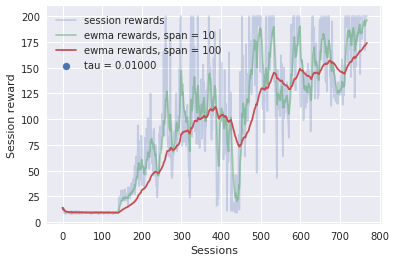

76389it [21:02, 68.35it/s]

You win!


In [ ]:
from itertools import count
s = env.reset()
current_reward = 0 #reward for current session
    
for i in tqdm(count()):
    
    ###Play###
    action = get_gumbel_action([s])[0] #a hat from gumbel(pi(a|s);tau)

    new_s,r,done,info = env.step(action.argmax())
    current_reward += r

    #record session history into buffer
    replay_buffer.add(s,action,r,new_s,done)
    
    s = new_s
    if done: 
        s = env.reset()
        session_rewards.append(current_reward)
        current_reward = 0
        if (len(session_rewards)+1)%10==0:
            draw_rewards()
            
        if np.mean(session_rewards[-25:]) > 195:
            print("You win!")
            break
        
        
    ###Train###        
    for _ in range(10): #increasae to get better sample efficiency
        states,actions,rewards,next_states,dones = replay_buffer.sample(32)
        train_critic(states,actions,rewards,next_states,dones)
        train_actor(states)
    
    target_net.load_weights(1)  #load less frequent to increase learning stability at the cost of speed


        

### Video

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(make_env(),directory="videos",force=True)

#play N games
for _ in range(100):
    returns = 0.
    s = env.reset()
    done = False
    while not done:
        s,r,done,_ = env.step(get_policy([s])[0].argmax()) #take greedy action
        returns += r
        
    print("total return = %f"%returns)


env.close()


[2017-06-16 16:07:40,583] Making new env: CartPole-v0
[2017-06-16 16:07:40,594] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-06-16 16:07:40,602] Starting new video recorder writing to /home/justheuristic/practical_rl/week6/videos/openaigym.video.0.24091.video000000.mp4
[2017-06-16 16:07:43,588] Starting new video recorder writing to /home/justheuristic/practical_rl/week6/videos/openaigym.video.0.24091.video000001.mp4


total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000


[2017-06-16 16:07:46,673] Starting new video recorder writing to /home/justheuristic/practical_rl/week6/videos/openaigym.video.0.24091.video000008.mp4


total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000


[2017-06-16 16:07:50,239] Starting new video recorder writing to /home/justheuristic/practical_rl/week6/videos/openaigym.video.0.24091.video000027.mp4


total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000


[2017-06-16 16:07:54,433] Starting new video recorder writing to /home/justheuristic/practical_rl/week6/videos/openaigym.video.0.24091.video000064.mp4


total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000


[2017-06-16 16:07:58,444] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/justheuristic/practical_rl/week6/videos')


total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000
total return = 200.000000


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

76389it [21:21, 59.61it/s]

### Instead of conclusions <a id="outro"></a>

Well, the algorithm evidently works. It ain't need no baseline. It trains off-policy which means that we can get osom sample efficiency. There's probably a lot of hacks like training several iterations of actor per every critic step and so on. Unlike gumbel-VAE and gumbel-GAN, we found that the algorithm is insensitive to $tau$ regime. It works well if $\tau$ is kept at a constant rate, provided it's reasonably small (0.1, 0.01).

The algorithm generalizes straightforwardly to any network architecture, so we gonna try it on some conv+lstm+attention for atari task. It also generalizes well on a mixture of continuous & discrete actions, which makes it tempting to try it on [[Universe]](http://universe.openai.com/) envs where there's a mixture of large discrete keyboard and continuous mouse space.

__Practically,__ the algorithm features good data efficiency due to experience replay and poor CPU efficiency, which makes it more applicable for tasks when sampling is costly. This includes both complex simulations (Universe, Starcraft, ...) and real world applications (physical robots, stock trading).

__Theoretically,__ the greatest strength of the algorithm is that it has less gradient variance than stochastic policy gradients (REINFORCE, A2c, TRPO). This is expected to play larger role when action space is large or ugly, like in Universe environments or for Seq2Seq tasks.

__Hopefully,__ i'll get to apply it to machine translation before my boss kills me :)

```

```
```

```
```

```
```

```
```

```
```

```
```

```


Thanks for reading this far. Here's a smiling hedgehog for your trouble:

<img src="https://www.demilked.com/magazine/wp-content/uploads/2014/04/marutaro-cute-hedgehog-funny-paper-faces-21.jpg" width=480>

### Appendix: critic training <a id="appendix"></a>

There are two general ways to train critic. One is a-la Q-learning (what we used) and the other is a-la Expected Value SARSA.

In EV-SARSA, you minimize
$$ \underset{<s,a,r,s'>}{E}(Q_\phi(s,a) - [r+\gamma \cdot \underset{gumbel}{E} \space Q_\phi(s', gumbel(\pi_\theta(a'|s'); \tau))])^2 $$

This algorithm can be better if you want to account for agent's constant exploration (e.g. for non-stationary environment) or if optimal policy is stochastic (e.g. rock-paper-scissors). 

The ball and chain is that you have to compute expected critic value over actor policy. Since both actor and critic are neural networks, this expectation is at best estimated with samples (this reads "long and inaccurate"). Q-learning, however, only ever requires a single evaluation of actor and critic.

__Possible hack:__ When training critic with expected-value SARSA, you have to compute $\underset{gumbel}{E} \space Q_\phi(s', gumbel(\pi_\theta(a|s'); \tau))$. This expectation can be honestly approximated by sampling gumbel one or more times, but you can do better by sacrificing your mathematical virginity.

Namely, replace this expectation with 

$$\underset{gumbel}{E} \space Q_\phi(s', gumbel(\pi_\theta(a|s'); \tau)) \approx Q_\phi(s', \underset{gumbel}{E} gumbel(\pi_\theta(a|s'); \tau)) \approx Q_\phi(s', \pi_\theta(a|s'))$$

This way algorithm becomes _kind of_ q-learning because it uses _kind of_ optimal action for V(s'). It will only work if you expect optimal policy to be deterministic.

In my defense, the algorithm still works with honest expectation, but you need more iterations to train critic that way. Also, since $Q_\phi(s,a)$ is a continuous function and $\pi_\theta(a|s)$ converges to a deterministic policy (always picks best action), this hack also converges to true expectation.

That's it. I feel slightly redeemed.
